In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

api_key=os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0,api_key=api_key)

llm.invoke("How to learn system design as a backend developer?").content

'Learning system design as a backend developer is a crucial step in advancing your career, especially if you\'re aiming for roles like software architect or senior developer. Here’s a structured approach to help you learn system design effectively:\n\n### 1. **Understand the Basics of System Design**\n   - **Concepts**: Familiarize yourself with key concepts such as scalability, reliability, availability, maintainability, and performance.\n   - **Components**: Learn about different components of a system, including databases, caching, load balancers, message queues, and microservices.\n\n### 2. **Study Design Principles**\n   - **SOLID Principles**: Understand the SOLID principles of object-oriented design.\n   - **Design Patterns**: Learn common design patterns (e.g., Singleton, Factory, Observer) and when to use them.\n   - **Microservices vs. Monoliths**: Understand the pros and cons of different architectural styles.\n\n### 3. **Learn About Distributed Systems**\n   - **CAP Theorem

## **Imports libraries**


In [2]:
from langgraph.graph import MessagesState,StateGraph,START,END
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import tools_condition
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from datetime import datetime
from IPython.display import Image, display


## **Memory adding**


In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## **States**


In [3]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## **Tools**


In [4]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


## **Binds tools with LLM**


In [8]:
def tool_calling_llm(state: MyState) -> MyState:
    """Call the LLM to get the result"""
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

## **Graph Builder**


In [9]:
builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
workflow = builder.compile(checkpointer=memory)

## **Graph**


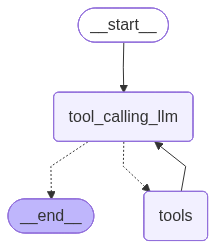

In [10]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [11]:
user_input = [HumanMessage(content="Now divide the previous result by 2")]
config={"configurable":{"thread_id":"123"}}
message=workflow.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Now divide the previous result by 2
================================== Ai Message ==================================

It seems that there is no previous result provided in our conversation. Could you please provide the number you would like to divide by 2?


1. Add Message reducer =>add_messages
2. Remove message =>RemoveMessage


## **Chatbot summarization**


In [144]:
from langchain_core.messages import SystemMessage,RemoveMessage
class ChatbotSummary(MessagesState):
    summary: str

In [145]:
def call_model(state: ChatbotSummary) -> ChatbotSummary:
    summary = state["messages"]
    
    if summary:
        # Add summary to the system message
        system_message = f"Here is the summary of the conversation: {summary}"
        messages = [SystemMessage(content=system_message)]+state["messages"]
    else:
        messages = state["messages"]
    llm_response = llm.invoke(messages)
    return {"messages": llm_response}

In [146]:
def summarize_conversation(state: ChatbotSummary) -> ChatbotSummary:
    summary = state["messages"]
    
    if summary:
        # Add summary to the system message
        system_message = (
            f"Here is the summary of the conversation:\n\n {summary}"
            "Extend the summary to include the latest conversation"
        )
    else:
        system_message = "Create a summary of the conversation above"
        
    messages = state["messages"]+[HumanMessage(content=system_message)]
    llm_response = llm.invoke(messages).content
    
    delete_message = [RemoveMessage(id=msg.id) for msg in state["messages"][:-2]]
    return {"summary":llm_response,"messages":delete_message}

In [147]:
from langgraph.graph import MessagesState,StateGraph,START,END

def should_continue(state: ChatbotSummary) -> str:
    """Determine whether to continue or not"""
    messages = state["messages"]
    
    if len(messages) > 6:
        result = "summarize_conversation"
    else:
        result = "end"
    
    return result

In [148]:
workflow = StateGraph(ChatbotSummary)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "end": END
    }
)

workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

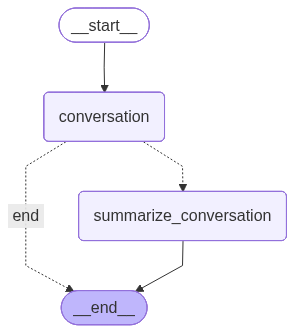

In [149]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [150]:
config={"configurable":{"thread_id":"123345"}}

In [151]:
user_input=[HumanMessage(content="Hii my name is EHtsham")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="What is my name?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="I like to play bedminton")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Ehtsham.
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message ===============

In [152]:
graph.get_state(config).values.get("summary")

In [153]:
user_input=[HumanMessage(content="I like hi Yuqi from China, is he the best player in the world?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

I like hi Yuqi from China, is he the best player in the world?
================================== Ai Message ==================================

Hi Yuqi is a talented badminton player, and he has achieved significant success in his career. However, whether he is considered the "best" player in the world can vary depending on current rankings and opinions. As of my last update, players like Kento Momota and Viktor Axelsen have also been regarded as top players. Rankings can change frequently, so it's always good to check the latest updates!


In [154]:
graph.get_state(config).values.get("summary")

'Sure! Here’s an extended summary of our conversation, including the latest exchanges:\n\n1. **Ehtsham Introduces Himself**: Ehtsham greets and shares his name.\n2. **AI Responds**: The AI responds warmly, asking how it can assist Ehtsham.\n3. **Ehtsham Asks About His Name**: Ehtsham inquires about his name.\n4. **AI Confirms Name**: The AI confirms that his name is Ehtsham.\n5. **Ehtsham Shares His Interest**: Ehtsham mentions that he likes to play badminton.\n6. **AI Responds Positively**: The AI acknowledges that badminton is a fun sport and asks how often Ehtsham plays.\n7. **Ehtsham Mentions Hi Yuqi**: Ehtsham expresses his admiration for Hi Yuqi from China and asks if he is the best player in the world.\n8. **AI Provides Information**: The AI responds that Hi Yuqi is a talented player but notes that the title of "best player" can vary based on rankings and opinions, mentioning other top players like Kento Momota and Viktor Axelsen.\n\nIf there\'s anything else you\'d like to add 

# **SQLlite memory**


In [155]:
import sqlite3

connection = sqlite3.connect(":memory:")

In [156]:
db_path = "memory.db"
connection = sqlite3.connect(db_path,check_same_thread=False)

In [157]:
from langgraph.checkpoint.sqlite import SqliteSaver

checkpointer = SqliteSaver(connection)


In [158]:
workflow = StateGraph(ChatbotSummary)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "end": END
    }
)

workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

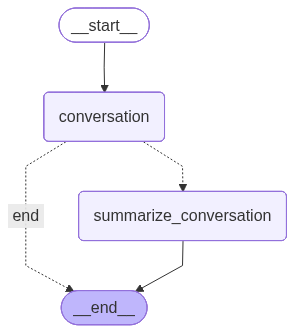

In [159]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [160]:
config={"configurable":{"thread_id":"sqlite_memory"}}

In [161]:
user_input=[HumanMessage(content="Hii my name is EHtsham")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="What is my name?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="I like to play bedminton")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Ehtsham.
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message ===========================

In [162]:
graph.get_state(config).values.get("summary")

'Sure! Here’s an extended summary of the conversation, including the latest exchanges:\n\n1. **User Introduction**: Ehtsham introduces himself.\n   - **User**: "Hii my name is EHtsham"\n   - **AI**: "Hi Ehtsham! Nice to meet you. How can I assist you today?"\n\n2. **Name Confirmation**: Ehtsham asks for confirmation of his name.\n   - **User**: "What is my name?"\n   - **AI**: "Your name is Ehtsham."\n\n3. **Interest in Badminton**: Ehtsham shares his interest in badminton.\n   - **User**: "I like to play bedminton."\n   - **AI**: "That\'s great! Badminton is a fun and fast-paced sport. How often do you play?"\n\n4. **Reintroduction**: Ehtsham reintroduces himself.\n   - **User**: "Hii my name is EHtsham."\n   - **AI**: "Hi Ehtsham! Welcome back! How can I assist you today?"\n\nIf there\'s anything specific you\'d like to add or discuss further, let me know!'

# **Streaming Response**


In [166]:
config_stream={"configurable":{"thread_id":"streaming_response"}}
user_input=[HumanMessage(content="Hii my name is EHtsham")]

for chunks in graph.stream({"messages": user_input},config_stream,stream_mode="update"):
    print(chunks)


In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()




llm = ChatOpenAI(model="gpt-4o-mini",api_key=os.getenv("OPENAI_API_KEY"))

# llm.invoke("How to learn system design as a backend developer?").content



In [2]:
llm.invoke("How to learn system design as a backend developer?").content

'Learning system design as a backend developer is an important step towards building scalable, robust, and efficient systems. Here’s a structured approach to help you get started:\n\n### 1. Understand Core Concepts\n- **Learn the Basics**: Understand fundamental concepts such as scalability, reliability, maintainability, and performance. Get a grasp on key principles of software engineering like SOLID principles, DRY (Don\'t Repeat Yourself), KISS (Keep It Simple, Stupid), etc.\n  \n- **Know the Components**:\n  - Distributed Systems: Understand how distributed systems work and their trade-offs.\n  - Databases: Get familiar with SQL vs. NoSQL, data modeling, indexing, and transactions.\n  - Caching: Learn about caching strategies and tools (e.g., Redis, Memcached).\n  - Load Balancers: Understand how load balancers work and their role in distributing traffic.\n  - Message Queues: Familiarize yourself with asynchronous communication through message queues (e.g., RabbitMQ, Kafka).\n  - M

In [ ]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

In [15]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
def assistant(state: MyState) -> MyState:
    messages = state["messages"]
    llm_response = llm.invoke(messages)
    return {"messages": [llm_response]}

In [18]:
workflow = StateGraph(MyState)
workflow.add_node("assistant", assistant)
workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", END)

graph = workflow.compile(checkpointer=MemorySaver())

In [32]:
from langchain_core.messages import HumanMessage
config={"configurable":{"thread_id":"123"}}
user_input=[HumanMessage(content="Hii my name is EHtsham")]

# for chunks in graph.stream({"messages": user_input},config,stream_mode="update"):
#     print(chunks)

async for events in graph.astream_events({"messages": user_input}, config, version="v2"):
    print(f"Node: {events.get('metadata', {}).get('langgraph_node')}. Type: {events.get('event')}. Name: {events.get('name')}")

Node: None. Type: on_chain_start. Name: LangGraph
Node: assistant. Type: on_chain_start. Name: assistant
Node: assistant. Type: on_chat_model_start. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_chat_model_stream. Name: ChatOpenAI
Node: assistant. Type: on_ch

In [34]:
from langchain_core.messages import HumanMessage

node_to_stream = "conversation"  # set to your actual node id
config = {"configurable": {"thread_id": "123abc"}}
user_input = [HumanMessage(content="what is the capital of Pakistan?")]

async for event in graph.astream_events({"messages": user_input}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node") == node_to_stream:
        data = event.get("data", {})
        print(data.get("chunk") or data)


# **Interrupt and Human in Loop**


In [31]:
from langchain.tools import tool
from langgraph.graph import StateGraph,END,START,MessagesState,add_messages
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from typing import TypedDict

In [32]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]    

In [33]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


In [34]:
def tool_calling_llm(state: MyState) -> MyState:
    """Call the LLM to get the result"""
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

In [35]:
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
workflow = builder.compile(interrupt_before=["tools"],checkpointer=memory)

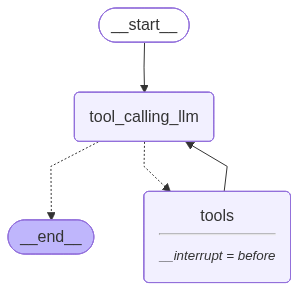

In [47]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [36]:
initial_messages = [HumanMessage(content="What is current date and time.")]
config={"configurable":{"thread_id":"1234"}}

for event in workflow.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time.
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_X7c5EfV60hXgGHuCo8Y2gmqv)
 Call ID: call_X7c5EfV60hXgGHuCo8Y2gmqv
  Args:
  get_current_time (call_HBHP5HwCsDd9Lx8L3lzMzWUA)
 Call ID: call_HBHP5HwCsDd9Lx8L3lzMzWUA
  Args:


In [37]:
state=workflow.get_state(config)
state.next

('tools',)

In [38]:
for events in workflow.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_X7c5EfV60hXgGHuCo8Y2gmqv)
 Call ID: call_X7c5EfV60hXgGHuCo8Y2gmqv
  Args:
  get_current_time (call_HBHP5HwCsDd9Lx8L3lzMzWUA)
 Call ID: call_HBHP5HwCsDd9Lx8L3lzMzWUA
  Args:
================================= Tool Message =================================
Name: get_current_time

2025-10-26 10:41:22
================================== Ai Message ==================================

The current date is October 26, 2025, and the current time is 10:41:22.


In [55]:
config={"configurable":{"thread_id":"1234"}}

In [56]:
initial_messages = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then add 10 to it")]

for event in workflow.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_approval = input("Do you want to continue? Yes/No")
if user_approval == "yes":
    for events in workflow.stream(None,config,stream_mode="values"):
        events["messages"][-1].pretty_print()
    
else:
    print("Workflow interrupted")

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then add 10 to it
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_9EDkuQRaF2pAQ3VN9RmnQghm)
 Call ID: call_9EDkuQRaF2pAQ3VN9RmnQghm
  Args:
  get_current_time (call_uGsODUFQRgmE7wjsXjmOyocU)
 Call ID: call_uGsODUFQRgmE7wjsXjmOyocU
  Args:
  multiply (call_yWbMeiGj2JyYp2OHuPI11Plz)
 Call ID: call_yWbMeiGj2JyYp2OHuPI11Plz
  Args:
    a: 18
    b: 8
  add (call_GKvQfWNG6Oo47XyufRJg6lVQ)
 Call ID: call_GKvQfWNG6Oo47XyufRJg6lVQ
  Args:
    a: 144
    b: 10
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_9EDkuQRaF2pAQ3VN9RmnQghm)
 Call ID: call_9EDkuQRaF2pAQ3VN9RmnQghm
  Args:
  get_current_time (call_uGsODUFQRgmE7wjsXjmOyocU)
 Call ID: call_uGsODUFQRgmE7wjsXjmOyocU
  Args:
  multiply (call_yWbMeiGj2JyYp2OHuP

In [57]:
initial_messages = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it")]

for event in workflow.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_approval = input("Do you want to continue? Yes/No")
if user_approval == "yes":
    for events in workflow.stream(None,config,stream_mode="values"):
        events["messages"][-1].pretty_print()
    
else:
    print("Workflow interrupted")

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_rdxbHmVAwJu9oqCXaFatWp2G)
 Call ID: call_rdxbHmVAwJu9oqCXaFatWp2G
  Args:
  get_current_time (call_xsAcwG696tH6uLPx9qDCYgF5)
 Call ID: call_xsAcwG696tH6uLPx9qDCYgF5
  Args:
  multiply (call_zvL4L7F39PRrwQ4dh6ZhXVrx)
 Call ID: call_zvL4L7F39PRrwQ4dh6ZhXVrx
  Args:
    a: 18
    b: 8
  divide (call_Js2IeP8rjsAl3GKERRVlDJyn)
 Call ID: call_Js2IeP8rjsAl3GKERRVlDJyn
  Args:
    a: 144
    b: 10
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_rdxbHmVAwJu9oqCXaFatWp2G)
 Call ID: call_rdxbHmVAwJu9oqCXaFatWp2G
  Args:
  get_current_time (call_xsAcwG696tH6uLPx9qDCYgF5)
 Call ID: call_xsAcwG696tH6uLPx9qDCYgF5
  Args:
  multiply (call_zvL4L7F39

In [59]:
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile(interrupt_before=["tool_calling_llm"],checkpointer=memory)

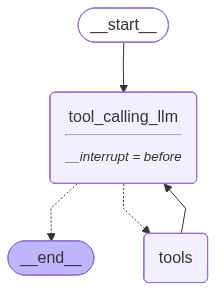

In [60]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
user_input = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it")]

config={"configurable":{"thread_id":"123@@"}}

In [62]:
for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it


In [63]:
state=graph.get_state(config)
state

StateSnapshot(values={'messages': [HumanMessage(content='What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it', additional_kwargs={}, response_metadata={}, id='852f9bff-8b94-4021-9efe-2d717deac264')]}, next=('tool_calling_llm',), config={'configurable': {'thread_id': '123@@', 'checkpoint_ns': '', 'checkpoint_id': '1f0adcad-fe54-6b52-8000-4b1e4774463a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-20T15:38:49.983036+00:00', parent_config={'configurable': {'thread_id': '123@@', 'checkpoint_ns': '', 'checkpoint_id': '1f0adcad-fe51-68e5-bfff-b84c21408a0c'}}, tasks=(PregelTask(id='d453c944-77d5-5230-2f05-475dc8f5daf2', name='tool_calling_llm', path=('__pregel_pull', 'tool_calling_llm'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [66]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No,Actually I want to add 20+19")]},
)
    

{'configurable': {'thread_id': '123@@',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0adcb4-c18f-613e-8004-8aa1f0438ac5'}}

In [67]:
new_state=graph.get_state(config).values
for msg in new_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it
================================ Human Message =================================

No,Actually I want to add 20+19
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_hJJhMFoOcnNOkIRcTujzOyCj)
 Call ID: call_hJJhMFoOcnNOkIRcTujzOyCj
  Args:
  get_current_time (call_qu0GjlQDbMDg65NFgeWcm80X)
 Call ID: call_qu0GjlQDbMDg65NFgeWcm80X
  Args:
  multiply (call_LntTLRBs8KcYM8aUCPchnkHu)
 Call ID: call_LntTLRBs8KcYM8aUCPchnkHu
  Args:
    a: 18
    b: 8
  add (call_cJOpozterShHF0byK54ofGfh)
 Call ID: call_cJOpozterShHF0byK54ofGfh
  Args:
    a: 20
    b: 19
================================= Tool Message =================================
Name: get_current_date

2025-10-20
================================= Tool Message =================================
Name: get_

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()


True

In [2]:
from langchain_openai import ChatOpenAI
openai_api_key = os.getenv("OPENAI_API_KEY")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("How to learn system design as a backend developer?").content

'Learning system design as a backend developer is a crucial step in advancing your career, especially if you\'re aiming for roles like software architect or senior developer. Here’s a structured approach to help you learn system design effectively:\n\n### 1. **Understand the Basics of System Design**\n   - **What is System Design?**: Familiarize yourself with the concepts of system design, including scalability, reliability, maintainability, and performance.\n   - **Key Components**: Learn about the fundamental components of system design, such as databases, caching, load balancers, message queues, and microservices.\n\n### 2. **Study Design Principles**\n   - **SOLID Principles**: Understand the SOLID principles of object-oriented design.\n   - **Design Patterns**: Learn common design patterns (e.g., Singleton, Factory, Observer) and when to use them.\n   - **Microservices vs. Monoliths**: Understand the differences, advantages, and disadvantages of microservices architecture compared

# **Human Interruption**


In [ ]:
from langchain_core.tools import tool
from langgraph.graph import StateGraph,END,START,MessagesState,add_messages
from langchain_core.messages import HumanMessage,AnyMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from typing import TypedDict,Annotated
from langgraph.prebuilt import tools_condition

In [11]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [39]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


In [41]:
def assistant(state: MyState) -> MyState:
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

## **Interrupt before tools**


In [42]:
workflow = StateGraph(MyState)
workflow.add_node("assistant", assistant)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", "tools")
workflow.add_edge("tools", "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("assistant", END)

graph = workflow.compile(interrupt_before=["tools"],checkpointer=MemorySaver())


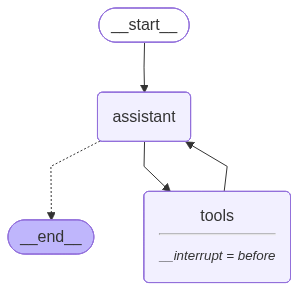

In [43]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
config={"configurable":{"thread_id":"123##"}}
user_input = [HumanMessage(content="What is current date and time")]

for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()   

================================ Human Message =================================

What is current date and time
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_BMvfHgMecUIxDRtmk01NvQ6r)
 Call ID: call_BMvfHgMecUIxDRtmk01NvQ6r
  Args:
  get_current_time (call_g2ehggufoszgAushmqLkvfRx)
 Call ID: call_g2ehggufoszgAushmqLkvfRx
  Args:


In [45]:
state=graph.get_state(config)
state.next

('tools',)

In [46]:
for events in graph.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()
# None is the message
# config is the previous thread id

================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_BMvfHgMecUIxDRtmk01NvQ6r)
 Call ID: call_BMvfHgMecUIxDRtmk01NvQ6r
  Args:
  get_current_time (call_g2ehggufoszgAushmqLkvfRx)
 Call ID: call_g2ehggufoszgAushmqLkvfRx
  Args:
================================= Tool Message =================================
Name: get_current_time

2025-10-26 10:42:20
================================== Ai Message ==================================

The current date is October 26, 2025, and the current time is 10:42:20.


In [47]:
config={"configurable":{"thread_id":"1234@@"}}
user_input = [HumanMessage(content="What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it")]

for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time.and what if we muliply 18 and 8 and then divide by 10 to it
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_LIZdq4TENpP0eLDk4sJDYN9D)
 Call ID: call_LIZdq4TENpP0eLDk4sJDYN9D
  Args:
  get_current_time (call_9zYiCNobVwpqKxkePZCA8AZv)
 Call ID: call_9zYiCNobVwpqKxkePZCA8AZv
  Args:
  multiply (call_UN8xWJBb4gbcfV8lpPgIxSbO)
 Call ID: call_UN8xWJBb4gbcfV8lpPgIxSbO
  Args:
    a: 18
    b: 8
  divide (call_nVErZbm5yOgMKdLiUnDn0Ajk)
 Call ID: call_nVErZbm5yOgMKdLiUnDn0Ajk
  Args:
    a: 144
    b: 10


In [ ]:
state2 = graph.get_state(config)
state2.next

('tools',)

In [49]:
for events in graph.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_LIZdq4TENpP0eLDk4sJDYN9D)
 Call ID: call_LIZdq4TENpP0eLDk4sJDYN9D
  Args:
  get_current_time (call_9zYiCNobVwpqKxkePZCA8AZv)
 Call ID: call_9zYiCNobVwpqKxkePZCA8AZv
  Args:
  multiply (call_UN8xWJBb4gbcfV8lpPgIxSbO)
 Call ID: call_UN8xWJBb4gbcfV8lpPgIxSbO
  Args:
    a: 18
    b: 8
  divide (call_nVErZbm5yOgMKdLiUnDn0Ajk)
 Call ID: call_nVErZbm5yOgMKdLiUnDn0Ajk
  Args:
    a: 144
    b: 10
================================= Tool Message =================================
Name: divide

14.4
================================== Ai Message ==================================

The current date is **October 26, 2025**, and the current time is **10:42:59**.

When you multiply 18 and 8, you get **144**. If you then divide that by 10, the result is **14.4**.


In [50]:
user_input = input("Enter your message")

user_input = [HumanMessage(content=user_input)]

for event in graph.stream({"messages": user_input},config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_permission = input("Do you want to continue? Yes/No")
if user_permission == "yes":
    for events in graph.stream(None,config,stream_mode="values"):
        events["messages"][-1].pretty_print()
else:
    print("Workflow interrupted")

================================ Human Message =================================

What is the current date and what is the sum of 14 and 5
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_KX0otO5Bdz49avlw3L8qsLji)
 Call ID: call_KX0otO5Bdz49avlw3L8qsLji
  Args:
  add (call_MnDSxuImaSrlZKnpl2Uf84id)
 Call ID: call_MnDSxuImaSrlZKnpl2Uf84id
  Args:
    a: 14
    b: 5
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_KX0otO5Bdz49avlw3L8qsLji)
 Call ID: call_KX0otO5Bdz49avlw3L8qsLji
  Args:
  add (call_MnDSxuImaSrlZKnpl2Uf84id)
 Call ID: call_MnDSxuImaSrlZKnpl2Uf84id
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

The current date is **October 26, 2025**, and the sum of 14 and 5 is **19**.


# **Interruption before Assistant**


In [51]:
workflow = StateGraph(MyState)
workflow.add_node("assistant", assistant)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", "tools")
workflow.add_edge("tools", "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("assistant", END)

graph = workflow.compile(interrupt_before=["assistant"],checkpointer=MemorySaver())


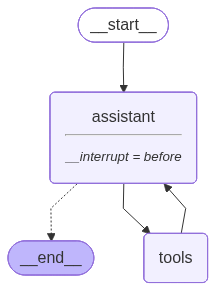

In [52]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
initial_messages = [HumanMessage(content="What is current date and time")]
config={"configurable":{"thread_id":"assistant_interruption"}}

for event in graph.stream({"messages": initial_messages},config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current date and time


In [55]:
state=graph.get_state(config)
state

StateSnapshot(values={'messages': [HumanMessage(content='What is current date and time', additional_kwargs={}, response_metadata={}, id='7a984b26-0894-4e4e-8a42-615962ee1353')]}, next=('assistant',), config={'configurable': {'thread_id': 'assistant_interruption', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22f6-2a5e-6989-8000-d74e27bb37e3'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T05:48:23.673268+00:00', parent_config={'configurable': {'thread_id': 'assistant_interruption', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22f6-2a5c-6771-bfff-7c0ff6cac43c'}}, tasks=(PregelTask(id='c9c6311f-ac14-446a-c9bc-a096f271d48a', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [56]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No,Actually I want to add 20+19")]},
)

{'configurable': {'thread_id': 'assistant_interruption',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b22f9-504e-6038-8001-a0da509b9f75'}}

In [57]:
new_state=graph.get_state(config).values
for msg in new_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is current date and time
================================ Human Message =================================

No,Actually I want to add 20+19


In [58]:
for events in graph.stream(None,config,stream_mode="values"):
    events["messages"][-1].pretty_print()

================================ Human Message =================================

No,Actually I want to add 20+19
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_vrECrnJ59fbOZqPS2wK9MnbT)
 Call ID: call_vrECrnJ59fbOZqPS2wK9MnbT
  Args:
  get_current_time (call_3HumKgPvIpnqoDiGoduUPHvZ)
 Call ID: call_3HumKgPvIpnqoDiGoduUPHvZ
  Args:
  add (call_v2TpzIaNmO3YrHOOwJQAc7FX)
 Call ID: call_v2TpzIaNmO3YrHOOwJQAc7FX
  Args:
    a: 20
    b: 19
================================= Tool Message =================================
Name: add

39


# **Node Interruption**


In [ ]:
from IPython.display import Image, display
from langgraph.types import interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,START,END
from typing import TypedDict

In [80]:
class NodeInterruptState(TypedDict):
    input:str

def step_1(state:NodeInterruptState) -> NodeInterruptState:
    print(f"Step 1: {state['input']}")
    return {"input":state['input']}

def step_2(state:NodeInterruptState) -> NodeInterruptState:
    if len(state["input"]) > 5:
        raise interrupt(f"Input is too long: {state['input']}")
    print(f"Step 2: {state['input']}")
    return {"input":state['input']}

def step_3(state:NodeInterruptState) -> NodeInterruptState:
    print(f"Step 3: {state['input']}")
    return {"input":state['input']}


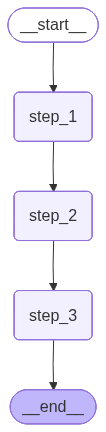

In [81]:
workflow = StateGraph(NodeInterruptState)
workflow.add_node("step_1", step_1)
workflow.add_node("step_2", step_2)
workflow.add_node("step_3", step_3)

workflow.add_edge(START, "step_1")
workflow.add_edge("step_1", "step_2")
workflow.add_edge("step_2", "step_3")
workflow.add_edge("step_3", END)

graph = workflow.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))

In [85]:
input_message={"input":"Hello world"}
config_interrupt={"configurable":{"thread_id":"123455!@"}}

for event in graph.stream(input_message,config=config_interrupt,stream_mode="values"):  
    print(event)  
    
    

{'input': 'Hello world'}
Step 1: Hello world
{'input': 'Hello world'}
{'__interrupt__': (Interrupt(value='Input is too long: Hello world', id='1152e7191fc80690b465fa0c67e77752'),)}


In [86]:
state=graph.get_state(config_interrupt)
state.next

('step_2',)

In [87]:
print(state.tasks)

(PregelTask(id='e2851d49-f3c9-171b-9bd3-9abb5532c19a', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Input is too long: Hello world', id='1152e7191fc80690b465fa0c67e77752'),), state=None, result=None),)


In [90]:
graph.update_state(config_interrupt,{"input":"Hello"})

{'configurable': {'thread_id': '123455!@',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2378-421d-6de9-800b-3c83773035d2'}}

In [91]:
for event in graph.stream(None,config=config_interrupt,stream_mode="values"):  
    print(event)  

{'input': 'Hello'}
Step 2: Hello
{'input': 'Hello'}
Step 3: Hello
{'input': 'Hello'}


# **Interrupt, command goto**


In [ ]:
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict

# ---- Define the state ----
class MyState(TypedDict):
    name: str
    approved: bool | None

# ---- Step 1 ----
def greet(state: MyState) -> MyState:
    print(f"👋 Hello, {state['name']}!")
    return state

# ---- Step 2 ----
def ask_for_approval(state: MyState) -> MyState:
    approval = interrupt({"message": f"Do you approve, {state['name']}? (yes/no)"})
    print(f"Received approval: {approval}")
    return {"name": state["name"], "approved": approval}

# ---- Step 3 ----
def finish(state: MyState) -> MyState:
    if state["approved"]:
        print(f"✅ Approved by {state['name']}")
    else:
        print(f"❌ Not approved by {state['name']}")
    return state

# ---- Build graph ----
workflow = StateGraph(MyState)
workflow.add_node("greet", greet)
workflow.add_node("ask_for_approval", ask_for_approval)
workflow.add_node("finish", finish)

workflow.add_edge(START, "greet")
workflow.add_edge("greet", "ask_for_approval")
workflow.add_edge("ask_for_approval", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile(checkpointer=MemorySaver())

# ---- STEP 1: Run the graph, expect interrupt ----
config = {"configurable": {"thread_id": "user123"}}

try:
    graph.invoke({"name": "Ehtsham", "approved": None}, config=config)
except Exception as e:
    print("Interrupted:", e)

# ---- STEP 2: Resume later (simulate user's choice) ----
graph.invoke(Command(resume=False), config=config)

👋 Hello, Ehtsham!
Received approval: False
❌ Not approved by Ehtsham


{'name': 'Ehtsham', 'approved': False}

In [107]:
# Each run/thread gets a unique ID
config = {"configurable": {"thread_id": "user123"}}

# Start execution
try:
    graph.invoke({"name": "Ehtsham"}, config=config)
except Exception as e:
    print("Interrupted:", e)


👋 Hello, Ehtsham!


In [102]:
all_states=[history for history in graph.get_state_history(config)]
all_states


[StateSnapshot(values={'name': 'Ehtsham', 'approved': False}, next=('ask_for_approval',), config={'configurable': {'thread_id': 'user123', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2391-1aa6-6af5-8001-88457ef9df20'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-26T06:57:42.774644+00:00', parent_config={'configurable': {'thread_id': 'user123', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2391-1aa4-6e53-8000-8225afc17bd9'}}, tasks=(PregelTask(id='7c1160a0-93e3-512b-436e-821e0c653038', name='ask_for_approval', path=('__pregel_pull', 'ask_for_approval'), error=None, interrupts=(Interrupt(value={'message': 'Do you approve, Ehtsham? (yes/no)'}, id='19b4d7fa3b260957f03e2eff483e7881'),), state=None, result=None),), interrupts=(Interrupt(value={'message': 'Do you approve, Ehtsham? (yes/no)'}, id='19b4d7fa3b260957f03e2eff483e7881'),)),
 StateSnapshot(values={'name': 'Ehtsham', 'approved': False}, next=('greet',), config={'configurable': {'thread_id': 'user123', 'che

In [ ]:
from typing import Literal
from langgraph.types import Command

class State(TypedDict):
    name:str
    approved:bool

def approved_nodes(state:State) -> Literal["proceed","cancel"]:
    is_approved = interrupt({
        "question":"Do you approve with this state?",
        "details":state["approved"]
    })
    if is_approved:
        return Command(goto="proceed")
    else:
        return Command(goto="cancel")


In [ ]:
from typing import TypedDict
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# ========== STATE DEFINITION ==========
class ToolReviewState(TypedDict):
    task_name: str
    tool_params: dict
    tool_result: dict | None
    approved: bool | None

# ========== STEP 1: PREPARE ==========
def step_prepare(state: ToolReviewState) -> ToolReviewState:
    print(f"Preparing task: {state['task_name']}")
    params = {"input": f"data for {state['task_name']}"}
    return {
        "task_name": state["task_name"],
        "tool_params": params,
        "tool_result": None,
        "approved": None,
    }

# ========== STEP 2: HUMAN REVIEW ==========
def step_human_review(state: ToolReviewState) -> ToolReviewState:
    # Pause so a human can decide
    review_payload = {
        "message": f"Please review tool params for '{state['task_name']}':",
        "tool_params": state["tool_params"],
    }
    approval = interrupt(review_payload)  # Pauses execution here
    print(f"Human responded with: {approval}")
    return {
        **state,
        "approved": approval.get("approved"),
        "tool_params": approval.get("tool_params", state["tool_params"]),
    }

# ========== STEP 3: EXECUTE TOOL ==========
def step_execute_tool(state: ToolReviewState) -> ToolReviewState:
    if not state["approved"]:
        print("❌ Tool execution skipped (not approved).")
        return state
    print(f"⚙️ Executing tool for '{state['task_name']}' with params: {state['tool_params']}")
    result = {"output": f"processed {state['tool_params']['input']}"}
    return {**state, "tool_result": result}

# ========== STEP 4: FINISH ==========
def step_finish(state: ToolReviewState) -> ToolReviewState:
    if state["approved"]:
        print(f"✅ Task '{state['task_name']}' completed. Result: {state['tool_result']}")
    else:
        print(f"❌ Task '{state['task_name']}' was not approved. No result.")
    return state


# ========== BUILD GRAPH ==========
workflow = StateGraph(ToolReviewState)
workflow.add_node("prepare", step_prepare)
workflow.add_node("human_review", step_human_review)
workflow.add_node("execute_tool", step_execute_tool)
workflow.add_node("finish", step_finish)

workflow.add_edge(START, "prepare")
workflow.add_edge("prepare", "human_review")
workflow.add_edge("human_review", "execute_tool")
workflow.add_edge("execute_tool", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile(checkpointer=MemorySaver())

Preparing task: AnalyzeData


In [111]:
# ========== RUN INTERACTIVELY ==========
if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-001"}}
    init_state = {
        "task_name": "AnalyzeData",
        "tool_params": {},
        "tool_result": None,
        "approved": None,
    }

    try:
        graph.invoke(init_state, config=config)
    except Exception as e:
        print("\n--- Workflow Paused ---")
        print("Interrupt payload:", e)
        print("-----------------------")

        # Ask the user whether they want to continue
        user_choice = input("Do you want to continue? (yes/no): ").strip().lower()
        approved = user_choice.startswith("y")

        # You can also let user edit params interactively
        if approved:
            new_input = input("Enter updated tool input (or press Enter to keep existing): ").strip()
            if new_input:
                tool_params = {"input": new_input}
            else:
                tool_params = {"input": "data for AnalyzeData"}
        else:
            tool_params = {"input": "data for AnalyzeData"}

        # Resume workflow
        resume_payload = {"approved": approved, "tool_params": tool_params}
        graph.invoke(Command(resume=resume_payload), config=config)


Preparing task: AnalyzeData


In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# ===== Define the state that moves through the graph =====
class ToolReviewState(TypedDict):
    task_name: str
    approved: bool | None
    tool_params: dict
    tool_result: dict | None


# ===== Step 1: Prepare the task =====
def prepare(state: ToolReviewState) -> ToolReviewState:
    print(f"🧩 Preparing task '{state['task_name']}'")
    return {**state, "tool_params": {"input": "raw data"}}


# ===== Step 2: Ask for human approval =====
def human_review(state: ToolReviewState) -> ToolReviewState:
    # This pauses execution and returns the interrupt payload to the outer script
    payload = {"message": f"Review task '{state['task_name']}'", "tool_params": state["tool_params"]}
    decision = interrupt(payload)
    print("Resumed with:", decision)
    return {**state, "approved": decision["approved"], "tool_params": decision["tool_params"]}


# ===== Step 3: Execute the tool =====
def execute_tool(state: ToolReviewState) -> ToolReviewState:
    if not state["approved"]:
        print("❌ Task not approved, skipping tool execution.")
        return {**state, "tool_result": None}
    print(f"⚙️ Executing tool with params: {state['tool_params']}")
    result = {"output": f"Processed: {state['tool_params']['input']}"}
    return {**state, "tool_result": result}


# ===== Step 4: Finish =====
def finish(state: ToolReviewState) -> ToolReviewState:
    if state["approved"]:
        print(f"✅ Task '{state['task_name']}' completed successfully!")
    else:
        print(f"🚫 Task '{state['task_name']}' was rejected.")
    return state


# ===== Build the workflow graph =====
workflow = StateGraph(ToolReviewState)
workflow.add_node("prepare", prepare)
workflow.add_node("human_review", human_review)
workflow.add_node("execute_tool", execute_tool)
workflow.add_node("finish", finish)

workflow.add_edge(START, "prepare")
workflow.add_edge("prepare", "human_review")
workflow.add_edge("human_review", "execute_tool")
workflow.add_edge("execute_tool", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile(checkpointer=MemorySaver())


# ===== Run interactively =====
if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-123"}}
    initial_state = {
        "task_name": "Analyze Sales Data",
        "approved": None,
        "tool_params": {},
        "tool_result": None,
    }

    # First run (until it pauses)
    try:
        print("\n🚀 Starting workflow...")
        graph.invoke(initial_state, config=config)
    except Exception as e:
        # The interrupt is raised here
        print("\n--- Workflow Paused ---")
        print(e)
        print("-----------------------")

        # Take user input now (outside the graph)
        user_choice = input("Do you want to continue? (yes/no): ").strip().lower()
        approved = user_choice.startswith("y")

        new_input = input("Enter updated input (or press Enter to keep 'raw data'): ").strip()
        if not new_input:
            new_input = "raw data"

        # Resume the graph
        resume_payload = {"approved": approved, "tool_params": {"input": new_input}}
        print("\n▶️ Resuming workflow...\n")
        graph.invoke(Command(resume=resume_payload), config=config)



🚀 Starting workflow...
🧩 Preparing task 'Analyze Sales Data'


# **Parallelism in langGraph**


In [ ]:
import operator
from typing import Annotated,TypedDict
from langgraph.graph import StateGraph,START,END

class MyState(TypedDict):
    state1:Annotated[list,operator.add]

In [16]:
class ReturnNodeValue:
    def __init__(self,value:str):
        self.value=value
    def __call__(self,state:MyState)->MyState:
        print(f"Returning {self.value} to {state['state1']}")
        return {"state1":self.value}

builder=StateGraph(MyState)
builder.add_node("a",ReturnNodeValue("I am A"))
builder.add_node("b",ReturnNodeValue("I am B"))
builder.add_node("c",ReturnNodeValue("I am C"))
builder.add_node("d",ReturnNodeValue("I am D"))

builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("b","c")
builder.add_edge("c","d")
builder.add_edge("d",END)

graph=builder.compile()

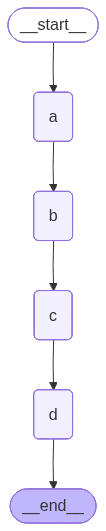

In [17]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
import numpy as np
class MyState(TypedDict):
    state1:Annotated[np.ndarray,operator.add]

class ReturnNodeValue:
    def __init__(self,value:str):
        self.value=value
    def __call__(self,state:MyState)->MyState:
        print(f"Returning {self.value} to {state['state1']}")
        return {"state1":np.array(self.value)}

builder=StateGraph(MyState)
builder.add_node("a",ReturnNodeValue("I am A"))
builder.add_node("b",ReturnNodeValue("I am B"))
builder.add_node("c",ReturnNodeValue("I am C"))
builder.add_node("d",ReturnNodeValue("I am D"))

builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("a","c")
builder.add_edge("b","d")
builder.add_edge("c","d")
builder.add_edge("d",END)

graph=builder.compile()

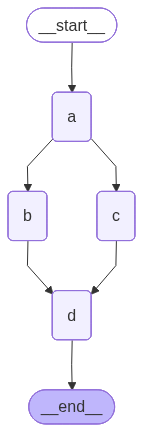

In [30]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state1":np.array("")})
except InvalidUpdateError as e:
    print(e)


Returning I am A to 
Returning I am B to I am A
Returning I am C to I am A
Returning I am D to I am AI am BI am C


In [64]:
def sorting_reducer(left, right):
    # Handle 0-d arrays
    if isinstance(left, np.ndarray) and left.ndim == 0:
        left = np.array([left.item()])
    elif not isinstance(left, np.ndarray):
        left = np.array([left])
    
    if isinstance(right, np.ndarray) and right.ndim == 0:
        right = np.array([right.item()])
    elif not isinstance(right, np.ndarray):
        right = np.array([right])
    
    # Fix concatenate - it needs a sequence, not individual args
    combined = np.concatenate([left, right])
    return np.array(sorted(combined))

In [65]:
import numpy as np
class MyState(TypedDict):
    state1:Annotated[np.ndarray,sorting_reducer]

class ReturnNodeValue:
    def __init__(self,value:str):
        self.value=value
    def __call__(self,state:MyState)->MyState:
        print(f"Returning {self.value} to {state['state1']}")
        return {"state1":np.array(self.value)}

builder=StateGraph(MyState)
builder.add_node("a",ReturnNodeValue("I am A"))
builder.add_node("b",ReturnNodeValue("I am B"))
builder.add_node("c",ReturnNodeValue("I am C"))
builder.add_node("d",ReturnNodeValue("I am D"))
builder.add_node("b2",ReturnNodeValue("I am B2"))
builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("a","c")
builder.add_edge("b","b2")
builder.add_edge("b2","d")
builder.add_edge("c","d")
builder.add_edge("d",END)

graph=builder.compile()

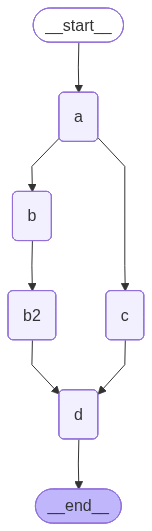

In [66]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))


In [67]:
try:
    graph.invoke({"state1":np.array("")})
except Exception as e:
    print(f"Error: {e}")


Returning I am A to 
Returning I am C to ['' 'I am A']
Returning I am B to ['' 'I am A']
Returning I am D to ['' 'I am A' 'I am B' 'I am C']
Returning I am B2 to ['' 'I am A' 'I am B' 'I am C']
Returning I am D to ['' 'I am A' 'I am B' 'I am B2' 'I am C' 'I am D']


# **Parallelism in Langgraph**


In [5]:
from typing import TypedDict,Annotated
import operator
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()



llm=ChatOpenAI(model="gpt-4o-mini",temperature=0,api_key=os.getenv("OPENAI_API_KEY"))

class ParallelState(TypedDict):
    question:str
    answer:str
    context:Annotated[list,operator.add]

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_tavily import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

# search=TavilySearchResults(max_results=4)
search=TavilySearchResults(max_results=4)

def web_search(state: ParallelState) -> ParallelState:
    docs = search.invoke(state["question"])
    print(f"DEBUG: docs types: {type(docs)},first item: {docs[0] if docs else 'No docs'}")
    
    formatted_search_docs = "\n\n----\n\n".join(
        f"<Document href={doc.get('url', 'N/A')}/>\n{doc.get('content', doc.get('snippet', str(doc)))}"
        for doc in docs
    )
    
    return {"context": [formatted_search_docs]}



def wiki_search(state: ParallelState) -> ParallelState:
    docs = WikipediaLoader(query=state["question"]).load()
    # WikipediaLoader returns Document objects with .page_content and .metadata
    formatted_wiki_docs = "\n\n----\n\n".join(
        f"<Document href={doc.metadata.get('source', 'N/A')}/>\n{doc.page_content}" 
        for doc in docs
    )
    
    return {"context": [formatted_wiki_docs]}

def generate_answer(state:ParallelState)->ParallelState:
    question=state["question"]
    context=state["context"]
    
    answer_template=f"""Answer the question using this context:{context}"""
    answer_instructions=answer_template.format(question=question,context=context)
    
    llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)
    answer=llm.invoke([SystemMessage(content=answer_instructions),HumanMessage(content=f"Answer the following question: {question}")])
    
    return {"answer":answer}

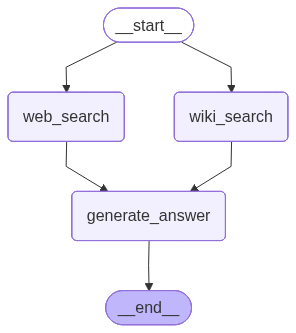

In [24]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
builder=StateGraph(ParallelState)
builder.add_node("web_search",web_search)
builder.add_node("wiki_search",wiki_search)
builder.add_node("generate_answer",generate_answer)

builder.add_edge(START,"web_search")
builder.add_edge(START,"wiki_search")
builder.add_edge("web_search","generate_answer")
builder.add_edge("wiki_search","generate_answer")
builder.add_edge("generate_answer",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
result=graph.invoke({"question":"What is the latest updates in AI?"})
print(result["answer"].content)

DEBUG: docs types: <class 'list'>,first item: {'title': 'The latest AI news we announced in September - Google Blog', 'url': 'https://blog.google/technology/ai/google-ai-updates-september-2025/', 'content': "# The latest AI news we announced in September\n\nOct 08, 2025\n\nHere’s a recap of some of our biggest AI updates from September, including an AI upgrade for Chrome, a new visual search option in AI Mode and the next step in bringing helpful robots into the physical world.\n\nSuperG\n\n## General summary [...] Forget pumpkin spice; the real news from September was the massive stack of AI updates. AI delivered major updates across our most popular core services like Chrome, Search and Android, making them significantly smarter. And the Gemini app became a powerhouse with its latest Gemini Drop, featuring the viral Nano Banana, Gemini Live, custom and shareable Gems, and the no-code app-building tool, Canvas. Meanwhile, even as we integrate AI across our digital products, Google Dee

# **SubGraphs**


In [19]:
from operator import add
class JobState(TypedDict):
    name: Annotated[list[str], add]
    job: str

def job_node(state):
    return {"job": "DevOps Engineer"}

def job_dummy_node(state):
    pass

class LocationState(TypedDict):
    name: Annotated[list[str], add]
    location: str

def location_node(state):
    return {"location": "Bangalore"}

def location_dummy_node(state):
    pass

job_builder = StateGraph(JobState)
job_builder.add_node("job_node", job_node)
job_builder.add_node("job_dummy_node", job_dummy_node)
job_builder.add_edge(START, "job_node")
job_builder.add_edge("job_node", "job_dummy_node")
job_builder.add_edge("job_dummy_node", END)
job_graph = job_builder.compile()

location_builder = StateGraph(LocationState)
location_builder.add_node("location_node", location_node)
location_builder.add_node("location_dummy_node", location_dummy_node)
location_builder.add_edge(START, "location_node")
location_builder.add_edge("location_node", "location_dummy_node")
location_builder.add_edge("location_dummy_node", END)
location_graph = location_builder.compile()

In [20]:
class ParentState(TypedDict):
    name: Annotated[list[str], add]
    job: str
    location: str
    details: str

def first_node(state: ParentState):
    return {"name": [state['name'][-1]]}

def last_node(state: ParentState):
    return {"details": f"{state['name'][-1]} is a {state['job']} at {state['location']}"}

In [21]:
entry_builder = StateGraph(ParentState)
entry_builder.add_node("first_node", first_node)
entry_builder.add_node("location_subgraph", location_graph)
entry_builder.add_node("job_subgraph", job_graph)
entry_builder.add_node("last_node", last_node)

entry_builder.add_edge(START, "first_node")
entry_builder.add_edge("first_node", "location_subgraph")
entry_builder.add_edge("first_node", "job_subgraph")
entry_builder.add_edge("location_subgraph", "last_node")
entry_builder.add_edge("job_subgraph", "last_node")
entry_builder.add_edge("last_node", END)

In [22]:
graph = entry_builder.compile()

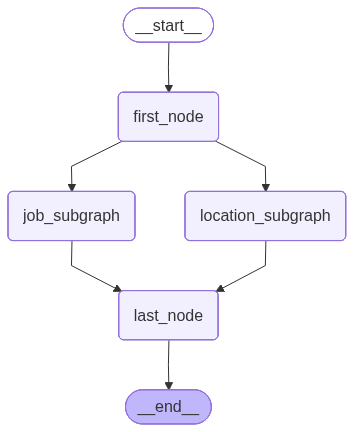

In [23]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))



# **Map and reducer**


In [ ]:
from operator import add
from typing import TypedDict,Annotated
from pydantic import BaseModel

# LangSmith Tracking Setup (RECOMMENDED METHOD)
# --------------------------------------------------
# Add these to your .env file:
# LANGCHAIN_TRACING_V2=true
# LANGCHAIN_API_KEY=your-langsmith-api-key-here
# LANGCHAIN_PROJECT=joke-generator
# 
# Then load_dotenv() will automatically enable tracking!
# No need to set os.environ manually.

In [14]:
class Subjects(BaseModel):
    joke_subjects:list[str]
class BestJokes(BaseModel):
    id:int
class Joke(BaseModel):
    joke:str

In [15]:
class OverAllJokesState(TypedDict):
    topics:str
    subjects:list
    subject:str  # Individual subject for each joke generation
    jokes:Annotated[list,add]
    best_selected_jokes:str

In [16]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

api_key=os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0,api_key=api_key)

# llm.invoke("How to learn system design as a backend developer?").content

In [17]:
subjects_Prompts = """Generate a comma separated list between 2 and 5 examples related to {topics}"""
jokes_prompt = """Generate jokes on following {topics}"""
best_jokes_prompt="""Below are bunch of jokes about {topics}.Select the best one and return the id of best one. Stating ) as Ids of best jokes."""


In [18]:
def generate_topics(state:OverAllJokesState):
    prompt=subjects_Prompts.format(topics=state['topics'])
    response=llm.with_structured_output(Subjects).invoke(prompt)
    return {
        "subjects":response.joke_subjects
    }

In [19]:
from langgraph.types import Send
def continue_to_jokes(state:OverAllJokesState):
    return [Send("generate_jokes",{"subject":s}) for s in state['subjects']]

In [20]:
def generate_jokes(state: OverAllJokesState):
    subject = state.get("subject")  # Use the specific subject sent via Send()
    prompt = jokes_prompt.format(topics=subject)
    response = llm.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


In [21]:
def best_jokes(state:OverAllJokesState):
    jokes="\n\n".join(state['jokes'])
    prompt=best_jokes_prompt.format(topics=state['topics'],jokes=jokes)
    response=llm.with_structured_output(BestJokes).invoke(prompt)
    return {"best_selected_jokes":state['jokes'][response.id]}

In [22]:
from IPython.display import Image,display
from langgraph.graph import START,END,StateGraph

graph=StateGraph(OverAllJokesState)
graph.add_node("generate_topics",generate_topics)
graph.add_node("generate_jokes",generate_jokes)
graph.add_node("best_jokes",best_jokes)

graph.add_edge(START,"generate_topics")
graph.add_conditional_edges("generate_topics",continue_to_jokes,["generate_jokes"])
graph.add_edge("generate_jokes","best_jokes")
graph.add_edge("best_jokes",END)

workflow=graph.compile()

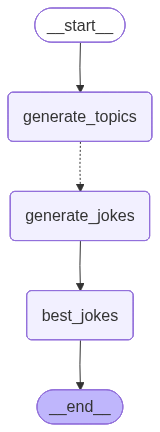

In [23]:
Image(workflow.get_graph().draw_mermaid_png())

In [25]:
for topic in workflow.stream({"topics":"cars"}):
    print(topic)

{'generate_topics': {'subjects': ["Why did the car break up with its girlfriend? It couldn't handle the emotional mileage.", 'What kind of car does a Jedi drive? A Toy-Yoda!', 'Why did the bicycle fall over? Because it was two-tired!', "What do you call a Ford Fiesta that won't start? A Ford Siesta!"]}}
{'generate_jokes': {'jokes': ["Why did the car break up with its girlfriend? \nIt couldn't handle the emotional mileage!"]}}
{'generate_jokes': {'jokes': ['What do you call a Ford Fiesta that only plays music? A Ford Siesta!']}}
{'generate_jokes': {'jokes': ['What kind of car does a Jedi drive? A Toy-Yoda!']}}
{'generate_jokes': {'jokes': ["Why did the bicycle get a flat tire? Because it couldn't handle the pressure!"]}}
{'best_jokes': {'best_selected_jokes': 'What do you call a Ford Fiesta that only plays music? A Ford Siesta!'}}


In [28]:
# Verify LangSmith tracking is enabled
import os
from dotenv import load_dotenv
load_dotenv()

print("🔍 Tracking Status:")
print(f"  LANGCHAIN_TRACING_V2: {os.getenv('LANGCHAIN_TRACING_V2', 'Not set')}")
print(f"  LANGCHAIN_PROJECT: {os.getenv('LANGCHAIN_PROJECT', 'Not set')}")
print(f"  LANGCHAIN_API_KEY: {'✅ Set' if os.getenv('LANGCHAIN_API_KEY') else '❌ Not set'}")


🔍 Tracking Status:
  LANGCHAIN_TRACING_V2: true
  LANGCHAIN_PROJECT: AI_Research
  LANGCHAIN_API_KEY: ✅ Set


# **Analyst**


In [2]:
from typing import TypedDict,List
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
load_dotenv()
memory_saver=MemorySaver()


In [3]:
from langchain_openai import ChatOpenAI
import os
llm=ChatOpenAI(model="gpt-4o-mini",temperature=0,api_key=os.getenv("OPENAI_API_KEY"))


In [4]:
class AnalyseState(BaseModel):
    affiliations:str=Field(description="Affiliations of the person")
    name:str=Field(description="Name of the analyst")
    role:str=Field(description="Role of the analyst in context of topic")
    description:str=Field(description="Description of the analyst,focus,concern and motives")
    
    @property
    def persona(self)->str:
        return f"Name:{self.name} \n Role:{self.role} \n Affiliation:{self.affiliations} \n Description:{self.description}"
    
class Perspective(BaseModel):
    analyst:List[AnalyseState]=Field(description="List of analysts with their perspective on the topic")
    
class GenerateAnalyst(TypedDict):
    topic:str
    max_analyst:int
    human_analyst_feedback:str
    analyst:List[AnalyseState]

In [5]:
analyst_instructions="""You are asked to create a set of AI analysts persons. Follow the instructions carefully.

1. First review the research topic {topic}
2. Examine any editorial feedback that has been provided. Optionally provide for the creation of analyst: {human_analyst_feedback}
3. Determine the most interesting theme based upon the documents or feedback above.
4. pick the top {max_analyst} analysts who are best suited for the theme.
5. Assign one analyst to each theme.
"""

In [6]:
def create_analyst(state:GenerateAnalyst):
    """create a list of analyst based on the instructions"""
    topic=state['topic']
    max_analyst=state['max_analyst']
    human_analyst_feedback=state.get("human_analyst_feedback","")
    structured_llm=llm.with_structured_output(Perspective)
    system_message=analyst_instructions.format(topic=topic,max_analyst=max_analyst,human_analyst_feedback=human_analyst_feedback)
    
    analyst=structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate a set of analyst")])
    
    return {"analyst":analyst.analyst}
    

In [7]:
def human_feedback(state:GenerateAnalyst):
    """provide human feedback to the analyst"""
    pass
def should_continue(state:GenerateAnalyst):
    human_feedback=state.get("human_analyst_feedback","")
    if human_feedback:
        return "create_analyst"
    return END

In [8]:
builder=StateGraph(GenerateAnalyst)
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback",human_feedback)
# builder.add_node("should_continue",should_continue)

builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst","human_feedback")

builder.add_conditional_edges("human_feedback",should_continue,["create_analyst",END])

graph=builder.compile(interrupt_before=['human_feedback'],checkpointer=memory_saver)


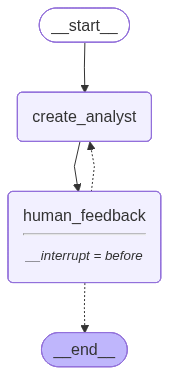

In [9]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
max_analyst=5
topic="How AI is ruling in Software Development? Is It danger for software jobs in Industry or it is making things easy for developers?"
thread= {"configurable":{"thread_id":"3"}}


for event in graph.stream({"topic":topic,"max_analyst":max_analyst},thread,stream_mode="values"):
    analysts=event.get("analyst",'')
    if analysts:
        for analyst in analysts:
            print(f"Name:{analyst.name}")
            print(f"Role:{analyst.role}")
            print(f"Affiliations:{analyst.affiliations}")
            print(f"Description:{analyst.description}")
            print("-"*100)

Name:Dr. Alice Thompson
Role:AI Impact Researcher
Affiliations:Tech Innovations Inc.
Description:Dr. Thompson focuses on the implications of AI in software development, analyzing both the potential job displacement and the efficiency gains for developers.
----------------------------------------------------------------------------------------------------
Name:Mr. John Carter
Role:Labor Market Analyst
Affiliations:Future of Work Institute
Description:Mr. Carter studies the evolving job landscape in the tech industry, assessing how AI tools are reshaping roles and responsibilities for software developers.
----------------------------------------------------------------------------------------------------
Name:Ms. Sarah Lee
Role:Software Development Strategist
Affiliations:Global Software Alliance
Description:Ms. Lee specializes in strategic planning for software companies, exploring how AI can enhance productivity while ensuring job security for developers.
------------------------------

In [11]:
state=graph.get_state(thread)
state.next

('human_feedback',)

In [12]:
graph.update_state(thread,{"human_analyst_feedback":"Add an analyst who is working in Google or Microsoft"},as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c215a-2eee-6709-8002-013c2cd38164'}}

In [13]:
for event in graph.stream(None ,thread,stream_mode="values"):
    analysts=event.get("analyst",'')
    if analysts:
        for analyst in analysts:
            print(f"Name:{analyst.name}")
            print(f"Role:{analyst.role}")
            print(f"Affiliations:{analyst.affiliations}")
            print(f"Description:{analyst.description}")
            print("-"*100)

Name:Dr. Alice Thompson
Role:AI Impact Researcher
Affiliations:Tech Innovations Inc.
Description:Dr. Thompson focuses on the implications of AI in software development, analyzing both the potential job displacement and the efficiency gains for developers.
----------------------------------------------------------------------------------------------------
Name:Mr. John Carter
Role:Labor Market Analyst
Affiliations:Future of Work Institute
Description:Mr. Carter studies the evolving job landscape in the tech industry, assessing how AI tools are reshaping roles and responsibilities for software developers.
----------------------------------------------------------------------------------------------------
Name:Ms. Sarah Lee
Role:Software Development Strategist
Affiliations:Global Software Alliance
Description:Ms. Lee specializes in strategic planning for software companies, exploring how AI can enhance productivity while ensuring job security for developers.
------------------------------

In [14]:
further_feeback=None
graph.update_state(thread,{"human_analyst_feedback":further_feeback},as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c215a-6544-625f-8004-32f19c60284a'}}

In [15]:
for event in graph.stream(None ,thread,stream_mode="updates"):
    print("----Node----")
    node_name=next(iter(event.keys()))
    print(node_name)

In [16]:
final_state=graph.get_state(thread)
analysts=final_state.values.get("analyst")

In [17]:
final_state.next

()

In [18]:
for analyst in analysts:
    print(f"Name:{analyst.name}")
    print(f"Role:{analyst.role}")
    print(f"Affiliations:{analyst.affiliations}")
    print(f"Description:{analyst.description}")
    print("-"*100)


Name:Dr. Emily Chen
Role:AI Research Scientist
Affiliations:Google
Description:Dr. Chen focuses on the integration of AI in software development processes. She is concerned about the balance between automation and job security for developers, advocating for AI as a tool to enhance productivity rather than replace human jobs.
----------------------------------------------------------------------------------------------------
Name:Mr. John Smith
Role:Software Development Manager
Affiliations:Microsoft
Description:Mr. Smith oversees AI-driven development tools at Microsoft. He believes that AI is revolutionizing the software industry by streamlining workflows and reducing repetitive tasks, ultimately empowering developers to focus on more complex problems.
----------------------------------------------------------------------------------------------------
Name:Ms. Sarah Johnson
Role:AI Ethics Specialist
Affiliations:IBM
Description:Ms. Johnson examines the ethical implications of AI in so

# **Conduct Interviews**


In [19]:
import operator
from typing import TypedDict,Annotated
from pydantic import BaseModel
from langgraph.graph import  MessagesState

class InterviewState(MessagesState):
    max_num_turns:int
    context:Annotated[list,operator.add]
    analyst:AnalyseState
    interview:str
    sections:list

In [20]:
question_instructions="""You are an analyst tasked with to interview an expert on the topic.You goal is to boil down the interesting and specific insights upon the topic.

1. Interesting: Insights that people will find surprising or non obvious.
2. Specific: Insights that are specific to the topic and not general knowledge.

Here is your topic of focus and goals:{goals}

Being start an Interview with the expert, begin with yourname that fits your persona and then ask the questions.
Continue to ask the questions to drill down and refine your understanding of the topic.
 When you are satisfied with your understanding then complete the interview with thank you so mucj for your help.
 
 Remember to stay in character and keep your responses concise and to the point.
"""

In [21]:
def generate_questions(state:InterviewState):
    """generate a list of questions based on the instructions"""
    analyst=state['analyst']
    messages=state['messages']
    
    # Generate questions
    system_message=question_instructions.format(goals=analyst.persona)
    questions=llm.invoke([SystemMessage(content=system_message)]+messages)
    
    return {"messages":questions}

# Generate Answers: Parallelization:

### The expert will gather information from multiple sources.

**/tmp/ipykernel_138789/551046412.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
search=TavilySearchResults(tavily_api_key=tavily_api_key)**


In [22]:
from pydantic import SecretStr
tavily_api_key=SecretStr(os.getenv("TAVILY_API_KEY"))
# print(tavily_api_key)

In [23]:
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3,api_key=tavily_api_key)

In [24]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string

In [25]:
search_instruction=SystemMessage(content="""You will be given a discussion between an analyst and an expert.your goal is to generate a well structure query for web search and for use in retrieval to the conversation.
                                 
First analyse the full conversation between the analyst and the expert.
Pay particular attention to the final question asked by the analyst.

connver the final question into a well structure query for web search.
""")
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}


In [26]:
class SearchQueryState(BaseModel):
    search_query:str=Field(description="Well structure query for web search")

In [27]:
def web_search(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQueryState)
    search_query = structured_llm.invoke([search_instruction]+state['messages'])
    
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


def wikipedia_search(state:InterviewState):
    structure_llm=llm.with_structured_output(SearchQueryState)
    structured_query=structure_llm.invoke([search_instruction]+state['messages'])
    
    search_docs=WikipediaLoader(query=structured_query.search_query,load_max_docs=3).load()
    
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    # Must return the list if you are using a list in the state
    return {"context":[formatted_search_docs]}

In [28]:
from langchain_core.messages import AIMessage
def save_interview(state:InterviewState):
    """save the Interview"""
    messages=state['messages']
    interview=get_buffer_string(messages)
    
    return {"interview":interview}
def route_messages(state:InterviewState,name:str="expert"):
    """Route between messages and answers"""
    messages=state['messages']
    max_num_turns=state.get('max_num_turns',10)
    
    # Check number of expert answers
    num_responses=len([m for m in messages if isinstance(m,AIMessage) and m.name==name])
    if num_responses >= max_num_turns:
        return "save_interview"
    last_message=messages[-2]
    if "Thank you so much for your help" in last_message.content:
        return "save_interview"
    return "ask_questions"    

In [29]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [30]:
def write_section(state:InterviewState):
    """write a section of the report"""
    context=state['context']
    analyst=state['analyst']
    # interview=state['interview']
    
    system_message=section_writer_instructions.format(focus=analyst.description)
    system_message = SystemMessage(
        content=section_writer_instructions.format(focus=analyst.description)
    )

    human_message = HumanMessage(
        content=f"Use this context to write a section of the report:\n\n{context}"
    )
    sections=llm.invoke([system_message,human_message])
    
    return {"sections":[sections.content]}

In [181]:
workflow=StateGraph(InterviewState)

workflow.add_node("ask_questions",generate_questions)
workflow.add_node("search_web",web_search)
workflow.add_node("search_wikipedia",wikipedia_search)
workflow.add_node("answer_questions",generate_answer)
workflow.add_node("save_interview",save_interview)
workflow.add_node("write_section",write_section)

# edges
workflow.add_edge(START,"ask_questions")
workflow.add_edge("ask_questions","search_web")
workflow.add_edge("ask_questions","search_wikipedia")
workflow.add_edge("search_web","answer_questions")
workflow.add_edge("search_wikipedia","answer_questions")
workflow.add_conditional_edges("answer_questions",route_messages,["ask_questions","save_interview"])
workflow.add_edge("save_interview","write_section")
workflow.add_edge("write_section",END)

interview_graph=workflow.compile(checkpointer=memory_saver).with_config(run_name="interview_graph")

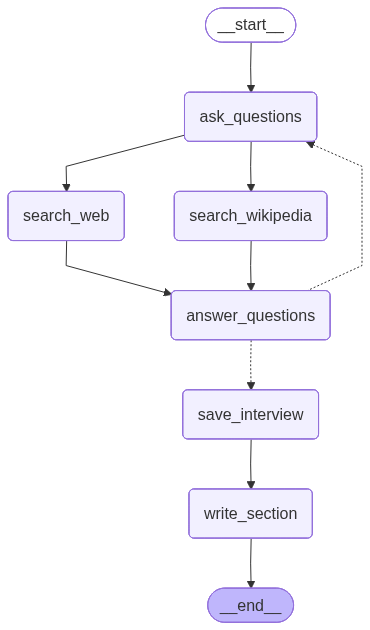

In [182]:
from IPython.display import Image,display
display(Image(interview_graph.get_graph().draw_mermaid_png()))


In [33]:
analysts[0]

AnalyseState(affiliations='Google', name='Dr. Emily Chen', role='AI Research Scientist', description='Dr. Chen focuses on the integration of AI in software development processes. She is concerned about the balance between automation and job security for developers, advocating for AI as a tool to enhance productivity rather than replace human jobs.')

In [ ]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## The Future of Software Development: Balancing AI Integration and Job Security

### Summary
The integration of artificial intelligence (AI) into software development processes is reshaping the industry, presenting both opportunities and challenges. Recent reports highlight that AI tools, particularly generative AI, are enhancing the productivity of software developers rather than replacing them. The US Bureau of Labor Statistics (BLS) reassures that AI is set to augment developers' capabilities, fostering demand for those who can navigate the evolving technological landscape [1]. Notably, tools like GitHub Copilot and emerging technologies such as Devin AI are revolutionizing coding practices by automating routine tasks, suggesting code completions, and even generating entire functions from natural language prompts [2][3]. 

Interestingly, studies indicate that less-experienced developers are benefiting the most from these AI tools, showing higher adoption rates and significant productivity gains [3]. This trend suggests that while AI may change the nature of software development, it is unlikely to diminish the need for human developers. Instead, it emphasizes the importance of human oversight and creativity in the development process, as AI tools still require validation and governance to ensure quality and accountability [4][5]. 

Moreover, the rise of AI-assisted software development is projected to lead to a significant increase in the number of developers utilizing these tools, with estimates suggesting that three out of four enterprise software engineers will be using AI code assistants by 2028 [6]. This shift not only enhances efficiency but also allows developers to focus on higher-level problem-solving, thereby redefining their roles within the industry [7]. 

However, the integration of AI also raises ethical questions and challenges regarding job security and intellectual property rights. As AI tools become more capable, the responsibilities of software engineers will inevitably evolve, necessitating a balance between leveraging AI for productivity and maintaining job security for human developers [8]. 

In conclusion, while the integration of AI in software development presents transformative potential, it is crucial to navigate the associated challenges thoughtfully to ensure that human developers remain an integral part of the process.

### Sources
[1] https://www.developer-tech.com/news/ai-impact-on-software-development-jobs/  
[2] https://www.brookings.edu/articles/how-ai-powered-software-development-may-affect-labor-markets/  
[3] https://mitsloan.mit.edu/ideas-made-to-matter/how-generative-ai-affects-highly-skilled-workers  
[4] https://www.ibm.com/think/topics/ai-in-software-development/  
[5] https://en.wikipedia.org/wiki/AI-assisted_software_development  
[6] https://www.wiz.io/academy/ai-software-development/  
[7] https://jellyfish.co/library/ai-in-software-development/  
[8] https://en.wikipedia.org/wiki/Artificial_intelligence  

## Use Send for parallel interview


In [173]:
from operator import add
from typing import Annotated,List,TypedDict
from langgraph.types import Send

class ResearchGraphState(TypedDict):
    topic:str
    max_analyst:int
    analyst:List[AnalyseState]
    human_analyst_feedback:str
    sections:Annotated[list,add]
    introduction:str
    content:str
    conclusion:str
    final_report:str


In [174]:
def initiate_all_interview(state: ResearchGraphState):
    human_feedback = state.get("human_analyst_feedback", "")
    if human_feedback:
        return "create_analyst"
    
    topic = state["topic"]

    return [
        Send(
            "conduct_interview",
            {
                "analyst": analyst,
                "topic": topic,
                "messages": [
                    HumanMessage(
                        content=f"So you said you are writing an article on: {topic}?"
                    )
                ],
            },
        )
        for analyst in state["analysts"]
    ]


In [175]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""


In [176]:
def write_report(state:ResearchGraphState):
    sections=state["section "]
    topic=state["topic"]
    
    formatted_sections = "\n\n---\n\n".join([section for section in sections])
    
    # summarize the sections into final reports
    
    system_message=report_writer_instructions.format(topic=topic,context=formatted_sections)
    report=llm.invoke([system_message])
    
    return {"content":report.content}

In [177]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


In [185]:
def write_conclusion(state:ResearchGraphState):
    sections=state["section "]
    topic=state["topic"]
    
    formatted_sections = "\n\n---\n\n".join([section for section in sections])
    
    # summarize the sections into final reports
    
    system_message=intro_conclusion_instructions.format(topic=topic,context=formatted_sections)
    conclusion=llm.invoke([system_message]+HumanMessage(content="Write a conclusion section"))
    
    return {"conclusion":conclusion.content}

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content="Write the report introduction")]) 
    return {"introduction": intro.content}

In [ ]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except Exception:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

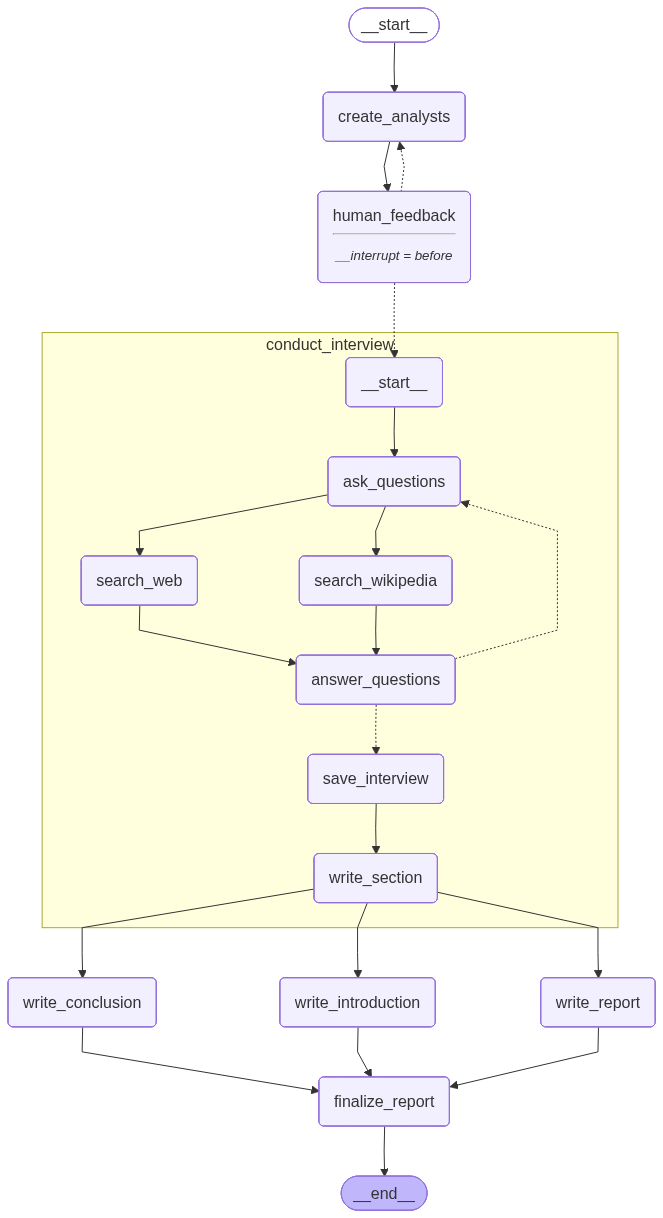

In [187]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", workflow.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interview, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [194]:
# Inputs
max_analyst = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "7"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analyst":max_analyst}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analyst', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliations}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the integration of AI frameworks in enterprise environments, emphasizing the scalability and adaptability of LangGraph for various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future Tech Research Group
Role: Data Science Analyst
Description: Mr. Liu specializes in data-driven decision-making and is particularly interested in how LangGraph can enhance data processing and analysis capabilities.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: AI Development Hub
Role: AI Ethics Consultant
Description: Ms. Thompson is concerned with the ethical implications of AI frameworks, advocating for responsible adoption of LangGraph while ensuring compliance with ethical standards.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: Tech Innovations In

# **Short Term vs Long Term Memory**

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the [Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [2]:
user_id="1"
namespace_for_memory=(user_id,"memories")
key=str(uuid.uuid4())
value={"food_Preferences":"I like pizza and pasta."}

In [3]:
in_memory_store.put(namespace_for_memory,key,value)

In [5]:
memories=in_memory_store.search(namespace_for_memory)
print(memories)
print(type(memories))

[Item(namespace=['1', 'memories'], key='954dbec1-acd1-437d-a762-f66596f45206', value={'food_Preferences': 'I like pizza and pasta.'}, created_at='2025-12-10T04:14:50.255139+00:00', updated_at='2025-12-10T04:14:50.255142+00:00', score=None)]
<class 'list'>


In [2]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model="gpt-4o-mini")

In [8]:
import uuid
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [10]:
import logging

logging.basicConfig(
    level=logging.INFO,             # Set log level
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger(__name__)


In [9]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

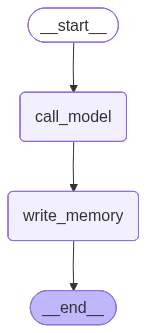

In [13]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    logger.info(f"Retrieving memory for user_id: {user_id}")
    # logger.info(f"Checking complete config: {config}")

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = llm.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

# Define the graph
builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

2025-12-11 08:00:08,684 - INFO - Retrieving memory for user_id: 1


================================ Human Message =================================

Hi, my name is Lance


2025-12-11 08:00:10,254 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I assist you today?


2025-12-11 08:00:11,410 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [15]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

2025-12-11 08:01:06,272 - INFO - Retrieving memory for user_id: 1


================================ Human Message =================================

I like to bike around San Francisco


2025-12-11 08:01:08,857 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

That sounds great, Lance! San Francisco has some beautiful routes for biking. Do you have a favorite area or trail that you like to ride?


2025-12-11 08:01:10,547 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


## Checking the memory

In [17]:
thread = {"configurable": {"thread_id": "1"}}
state=graph.get_state(thread).values
# logger.info("Final state memory:{}".format(state))
for msg in state['messages']:
    msg.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds great, Lance! San Francisco has some beautiful routes for biking. Do you have a favorite area or trail that you like to ride?


In [18]:
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "Here’s the updated user information:\n\n- Name: Lance\n- Location: San Francisco\n- Preferences: Likes biking\n\nIf there's anything else you'd like to share or update, feel free to let me know!"},
 'created_at': '2025-12-11T03:01:10.557383+00:00',
 'updated_at': '2025-12-11T03:01:10.557392+00:00'}

In [19]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

2025-12-11 08:06:08,924 - INFO - Retrieving memory for user_id: 1


================================ Human Message =================================

Hi! Where would you recommend that I go biking?


2025-12-11 08:06:14,224 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Hey, Lance! Since you're in San Francisco and enjoy biking, I recommend checking out the Golden Gate Park. It has beautiful trails and stunning views. You could also ride across the Golden Gate Bridge for a memorable experience. If you're up for a challenge, consider heading to Marin Headlands for some scenic routes with breathtaking views of the Bay. Enjoy your ride!


2025-12-11 08:06:16,968 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [20]:
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

2025-12-11 08:06:56,550 - INFO - Retrieving memory for user_id: 1


================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.


2025-12-11 08:07:01,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Absolutely! After your bike ride, you can treat yourself to some delicious croissants. Here are a few bakeries in San Francisco that you might enjoy:

1. **Tartine Bakery** - Known for its incredible pastries, you can find some of the best croissants here. It's a bit of a drive from Golden Gate Park, but worth it.

2. **Beard Papa's** - This bakery is famous for its cream puffs, but they also offer tasty croissants.

3. **B Patisserie** - Located in Pacific Heights, this place has a variety of pastries, and their croissants are highly praised.

4. **Arizmendi Bakery** - This co-op bakery has a more casual vibe and offers delightful options including croissants.

Give any of these a try after your bike ride! Enjoy!


2025-12-11 08:07:03,676 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [21]:
import os
import getpass

def _set_env(var:str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"Enter value for {var}: ")
    os.environ[var] = env_value

In [23]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="LangGraph Memory Store Example"

In [24]:
from typing import TypedDict,List

class UserProfile(TypedDict):
    user_name:str
    interests:List[str]

In [26]:
user_profile = UserProfile(
    user_name="Alice",
    interests=["hiking", "photography", "cooking"]
)
logger.info(f"User Profile: {user_profile}")

2025-12-11 08:22:27,832 - INFO - User Profile: {'user_name': 'Alice', 'interests': ['hiking', 'photography', 'cooking']}


In [27]:
# Storing dict to our store
in_memory_store = InMemoryStore()
user_id="alice_123"
namespace_for_memory = ("memory", user_id)
key = "user_profile"
value = user_profile

in_memory_store.put(namespace_for_memory, key, value)

In [28]:
for msg in in_memory_store.search(namespace_for_memory):
    logger.info(msg.dict())

2025-12-11 08:25:16,069 - INFO - {'namespace': ['memory', 'alice_123'], 'key': 'user_profile', 'value': {'user_name': 'Alice', 'interests': ['hiking', 'photography', 'cooking']}, 'created_at': '2025-12-11T03:24:29.248260+00:00', 'updated_at': '2025-12-11T03:24:29.248266+00:00', 'score': None}


## **Chatbot with Collection Schema**

In [29]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [30]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Ehtsham. I like to bike.")])
memory_collection.memories

2025-12-11 08:44:02,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[Memory(content="User's name is Ehtsham."),
 Memory(content='User likes to bike.')]

In [33]:
logger.info(memory_collection.memories[0].model_dump())
logger.info(memory_collection.memories[1].model_dump())

2025-12-11 08:45:19,819 - INFO - {'content': "User's name is Ehtsham."}
2025-12-11 08:45:19,820 - INFO - {'content': 'User likes to bike.'}


In [34]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [35]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '5ec99628-6f99-460e-9405-6aeedd806523', 'value': {'content': "User's name is Ehtsham."}, 'created_at': '2025-12-11T03:45:53.182643+00:00', 'updated_at': '2025-12-11T03:45:53.182645+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '052c6905-fb29-4264-bf8c-2ddc59a5eb16', 'value': {'content': 'User likes to bike.'}, 'created_at': '2025-12-11T03:45:53.182843+00:00', 'updated_at': '2025-12-11T03:45:53.182845+00:00', 'score': None}


In [36]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [37]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

2025-12-11 08:48:16,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [38]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_4QJfJxMgMBRGV6PeeLr5qv3V)
 Call ID: call_4QJfJxMgMBRGV6PeeLr5qv3V
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [39]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_4QJfJxMgMBRGV6PeeLr5qv3V'}


In [40]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]

In [41]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

2025-12-11 08:49:44,427 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [42]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_xGiepVYRSYkY5t5hVRMg30FY)
 Call ID: call_xGiepVYRSYkY5t5hVRMg30FY
  Args:
    content: Lance had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and planning to go back this winter.
  Memory (call_sKXlr8p6bKyGOLJpUwX8a7BP)
 Call ID: call_sKXlr8p6bKyGOLJpUwX8a7BP
  Args:
    content: Lance was thinking about Japan and planning to go back this winter.


In [43]:
llm.invoke([SystemMessage(content="Hello, how can I assist you today?")])

2025-12-11 09:15:22,565 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content="I'm here to help with any questions or information you need! Whether you have inquiries about a specific topic, need assistance with a task, or just want to chat, feel free to let me know how I can assist you today.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 16, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'id': 'chatcmpl-ClSNFbyTYWsLi008VeYSe5R69VJPV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--5fdc6ad6-4ede-4f93-9d27-b050f9f008d1-0', usage_metadata={'input_tokens': 16, 'output_tokens': 46, 'total_tokens': 62, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_t